<a href="https://colab.research.google.com/github/LuizFelipe2812/Mestrado_FACOM/blob/main/Implementa%C3%A7%C3%A3o_CNN_Luiz_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Teste para implementação

Este modelo inicial é um baseline, utilizando as bases de dados presente no Keras.

In [ ]:
"""
Importação das bibliotecas necessárias para implementação

"""

import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow.keras

from matplotlib import pyplot
from PIL import Image
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from keras.datasets import cifar10


In [ ]:
# Carregando dataset que será utilizado
(trainX, trainY), (testX, testY) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


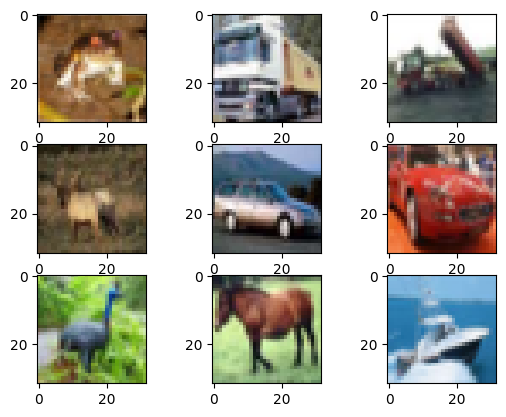

In [ ]:
# Plotando algumas imagens do Dataset
for i in range(9):
 pyplot.subplot(330 + 1 + i)
 pyplot.imshow(trainX[i])
pyplot.show()

In [ ]:
# Pré-processamento dos dados
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [ ]:
# Gera uma função para segmentar o dataset em dados de treino e teste
"""
def load_dataset():
 # carrega o dataset
 (trainX, trainY), (testX, testY) = cifar10.load_data()

 trainY = to_categorical(trainY)
 testY = to_categorical(testY)
 return trainX, trainY, testX, testY """

'\ndef load_dataset():\n # carrega o dataset\n (trainX, trainY), (testX, testY) = cifar10.load_data()\n\n trainY = to_categorical(trainY)\n testY = to_categorical(testY)\n return trainX, trainY, testX, testY '

In [ ]:
# Construir o modelo da CNN

model = Sequential() # Cria um modelo Sequential, que é uma pilha linear de camadas de rede neural.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))) # Adiciona uma camada de convolução Conv2D à rede
model.add(MaxPooling2D((2, 2))) # Adiciona uma camada de pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Para evitar o overfitting, adicionamos uma camada de Dropout
model.add(Dense(10, activation='softmax'))


In [ ]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
# Treinar o modelo
history = model.fit(trainX, trainY,
          epochs=20,      # Indica o número de épocas de treinamento
          batch_size=64, #  Define o tamanho do lote (batch size) utilizado durante o treinamento.
          validation_split=0.1 # Proporção da base de validação
          )

Epoch 1/20
704/704 [==============================] - 84s 117ms/step - loss: 1.7305 - accuracy: 0.3573 - val_loss: 1.3941 - val_accuracy: 0.4986
Epoch 2/20
704/704 [==============================] - 77s 109ms/step - loss: 1.3676 - accuracy: 0.5072 - val_loss: 1.2221 - val_accuracy: 0.5624
Epoch 3/20
704/704 [==============================] - 79s 112ms/step - loss: 1.2067 - accuracy: 0.5722 - val_loss: 1.0785 - val_accuracy: 0.6144
Epoch 4/20
704/704 [==============================] - 79s 112ms/step - loss: 1.0897 - accuracy: 0.6181 - val_loss: 0.9802 - val_accuracy: 0.6584
Epoch 5/20
704/704 [==============================] - 82s 117ms/step - loss: 1.0094 - accuracy: 0.6501 - val_loss: 0.9186 - val_accuracy: 0.6818
Epoch 6/20
704/704 [==============================] - 85s 120ms/step - loss: 0.9366 - accuracy: 0.6751 - val_loss: 0.8777 - val_accuracy: 0.6940
Epoch 7/20
704/704 [==============================] - 78s 111ms/step - loss: 0.8771 - accuracy: 0.6941 - val_loss: 0.8332 - val_ac

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9168766736984253
Test accuracy: 0.7206000089645386


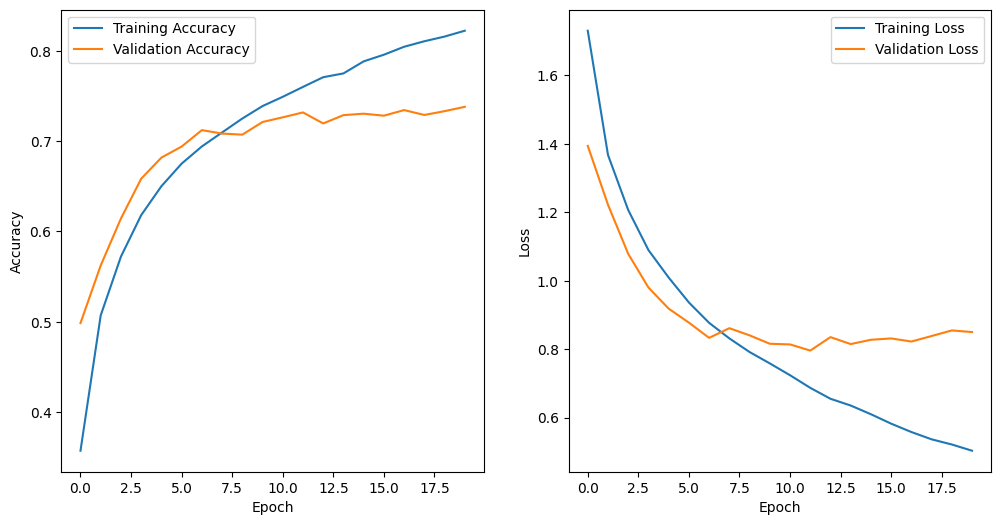

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model Evaluation Test Harness

In [ ]:
"""
Importação das bibliotecas necessárias para implementação

"""

import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow.keras

from matplotlib import pyplot
from PIL import Image
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import Model
from keras.datasets import cifar10

In [ ]:
# Carregando dataset que será utilizado
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [ ]:
# Pré-processamento dos dados
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [ ]:
model = Sequential() # Cria um modelo Sequential, que é uma pilha linear de camadas de rede neural.

# Camadas de convolução e max pooling
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# Camadas totalmente conectadas
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Camada de saída com 10 unidades e softmax


In [ ]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
"""
ValueError: Shapes (None, 10) and (None, 32, 32, 3) are incompatible

Retorna o seguinte erro:

O erro que você está enfrentando é devido a uma incompatibilidade entre as dimensões
dos dados de entrada e saída na função de perda categorical_crossentropy.
 """


# fit model
history = model.fit(trainX, trainY,
                    epochs=20,
                    batch_size=64,  #  Define o tamanho do lote (batch size) utilizado durante o treinamento.
                    validation_data=(testX, testY), verbose=0)

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9276838898658752
Test accuracy: 0.7342000007629395


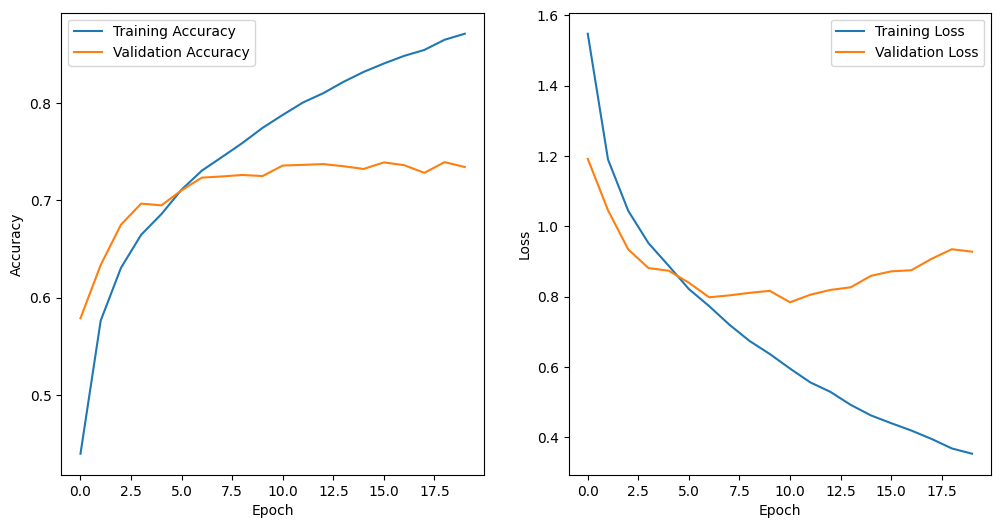

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Desenvolvendo Modelo Baseline

Utilizando 1 VGG

In [ ]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [ ]:

# fit model
history_1vgg = model.fit(trainX, trainY,
                         epochs=20,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3832626342773438
Test accuracy: 0.7268999814987183


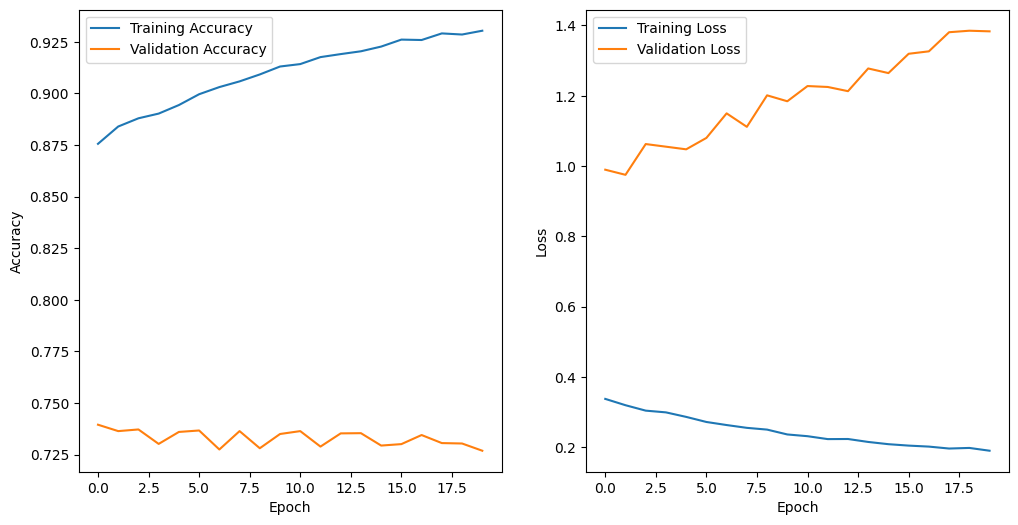

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_1vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1vgg.history['loss'], label='Training Loss')
plt.plot(history_1vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Utilizando 2 VGG

In [ ]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [ ]:
# fit model
history_2vgg = model.fit(trainX, trainY,
                         epochs=20,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7196390628814697
Test accuracy: 0.7285000085830688


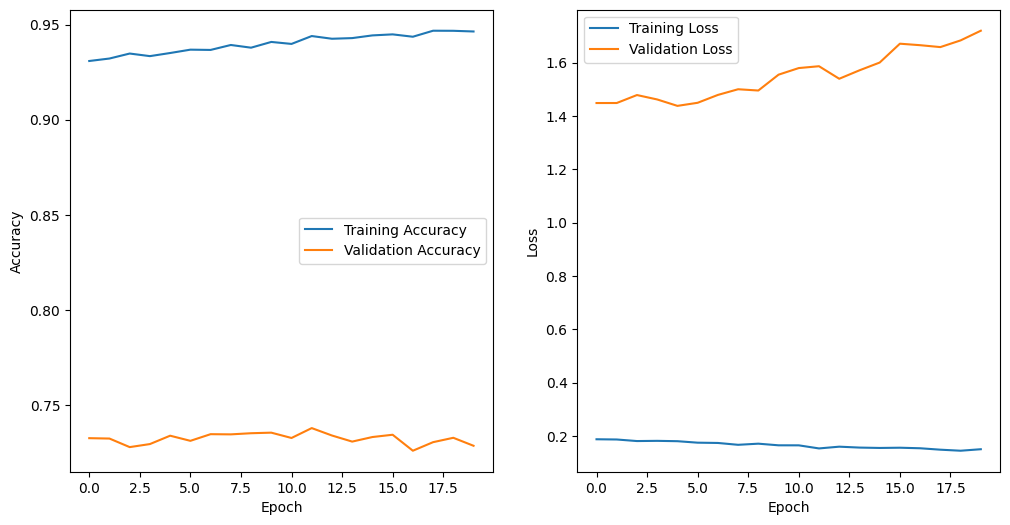

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_2vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2vgg.history['loss'], label='Training Loss')
plt.plot(history_2vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Utilizando 3 VGG

In [ ]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [ ]:
# fit model
history_3vgg = model.fit(trainX, trainY,
                         epochs=20,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.89082932472229
Test accuracy: 0.7293999791145325


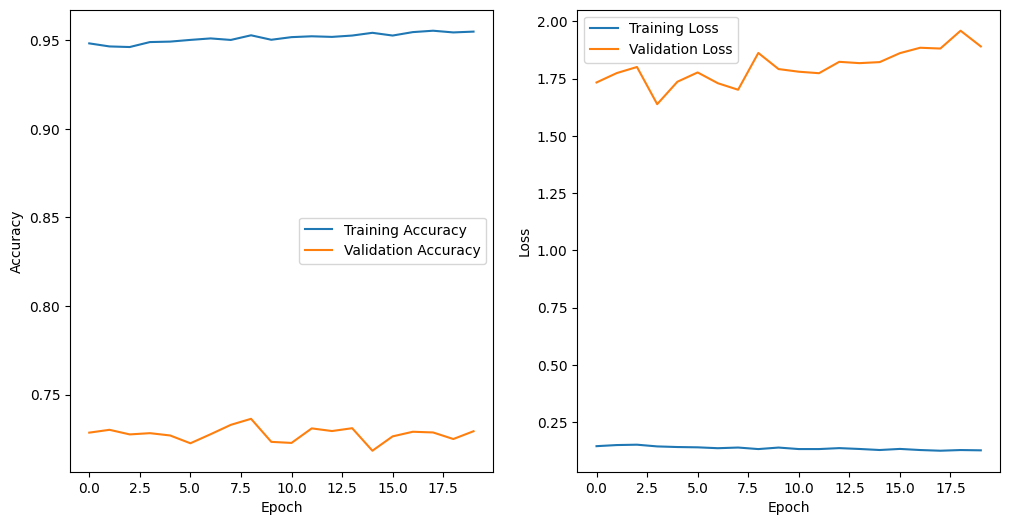

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_3vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_3vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3vgg.history['loss'], label='Training Loss')
plt.plot(history_3vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Utilizando 3 VGG com Dropout

In [ ]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dropout(0.2))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [ ]:
# fit model
history_3vgg_dropout = model.fit(trainX, trainY,
                         epochs=20,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.200929880142212
Test accuracy: 0.725600004196167


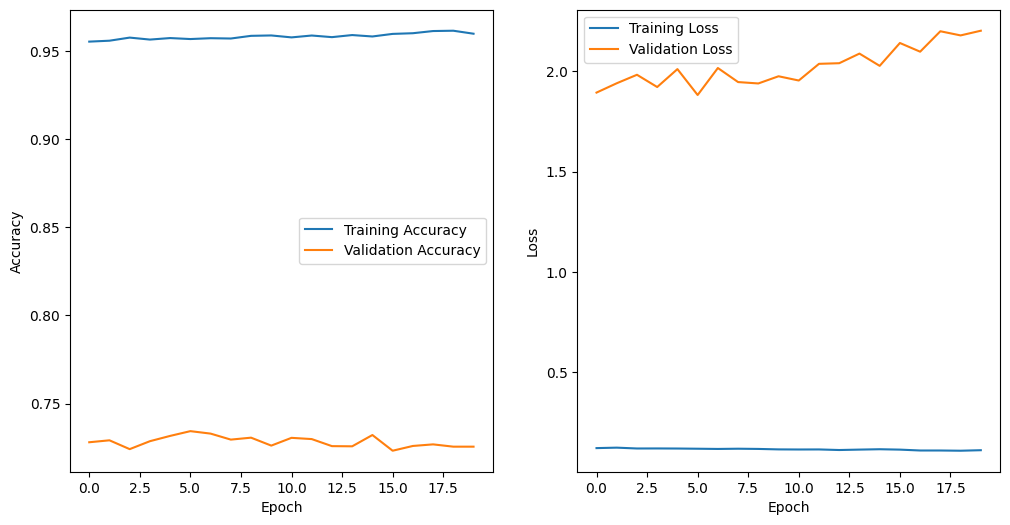

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_3vgg_dropout.history['accuracy'], label='Training Accuracy')
plt.plot(history_3vgg_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3vgg_dropout.history['loss'], label='Training Loss')
plt.plot(history_3vgg_dropout.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()